# Cell segmentation in byc
The workflow for segmentation is a combination of manual annotation in imagej assisted by plugins and macros in `imagejpc` and data processing in python with functions from `byc.segmentation`

## ImageJ scripts (imagejpc) installation 
### Clone `imagejpc` repo

```sh
git clone https://github.com/johnpcooper/imagejpc.git
tree imagejpc
imagejpc
├── Keyboard_Shortcuts.xls
├── README.md
├── macros
│   ├── create_and_measure_rois.ijm
│   ├── scale_rois.ijm
│   └── threshold_brightfield.ijm
└── utilities
    ├── get_percentile.py
    ├── measure_and_clear_rois.py
    ├── measure_background.py
    ├── measure_rois.py
    ├── measure_steady_state.py
    ├── record_cell.py
    ├── save_cell_measurement_rois.py
    ├── save_cell_roi_set.py
    ├── save_rois.py
    ├── save_tifs.py
    ├── split_and_save_stack.py
    └── time_stamper_jpc.py
```

### Get plugins and macros installed in `imagejpc`
1. Install [Fiji](https://imagej.net/Fiji/Downloads) if not already installed.


2. Open imagej, click Plugins > Macros > Install > Select macros (one at a time, ugh) from path/to/imagejpc/macros


3. Click Plugins > Install PlugIn > Select .py files (one at a time) from path/to/imagejpc/utilities


4. Click Plugins > Shortcuts > Add Shortcut... to make shortcut for shortcuts in `Keyboard_Shortcuts.xls`


4. Restart imagej to complete installation

## Creating cell ROIs in Imagej
Use Imagej to annotate cell locations and bud appearance timepoints on aligned FOV stacks (one for each channel collected in the experiment

An experiment directory should look something like

```sh
tree 20200221_byc_analysis
20200221_byc_analysis
├── 20200221_byc_analysis
├── 20200221_byc_master_index.csv
├── 20200221_byc_notes.txt
└── pJC069_rpn4d
    ├── 20200221_byc_xy00_bf_stack.tif
    ├── 20200221_byc_xy00_dsred_stack.tif
    ├── 20200221_byc_xy00_yfp_stack.tif
    ├── 20200221_byc_xy01_bf_stack.tif
    ├── 20200221_byc_xy01_dsred_stack.tif
    └── 20200221_byc_xy01_yfp_stack.tif
```

`20200221_byc_master_index.csv` is an index with a different row for each cell and information about where to find that cell's ROIs, which xy it was found in, where to find measurement .csvs etc. 

### Crop (tracking) ROIs
These ROIs will be used in `byc.segmentation` to crop cells from each channel in the cell's source FOV stack and threshold a fluorescent channel chosen by the user. 

1. Open a brightfield and/or fluorescent channels FOV stack(s) in Imagej


2. To create a crop ROI, draw a rectangular selection around the mother cell to be tracked and press t to add it to RoiManager


3. Each ROI should have the mother cell approximately centered and should exclude any other cells in the same catch tube. 


4. First ROI should be when cell first appears in experiment


5. Make a new ROI every time the cell moves out of the center of the ROI (whether because a division moves it or a registration issue)


6. Last ROI should be either last frame cell was seen alive, or whenever the user wants to end trace


7. Once you've finished adding crop ROIs to RoiManager, press l to focus the Imagej search bar, then type 'save cell roi set'. Type 'crop' for roi set type and whatever the end event type was. Information about this cell then gets added to the results table and you can do what you want with that. I will eventually merge these results with the `master_index.csv` to streamline information gathering

The `save_cell_roi_set.py` plugin will save the crop set in the active image directory with:

```python
roi_set_fn = '{}_cell{}_{}_rois'.format(expt_title, cell_index, roi_set_type)
```

`cell_index` is a three digit number (eg 001) generated by looking in the active image directory, and counting the number of `.roi` or `.zip` (ROI format) files in that directory. So if you have bud or measurement ROI.zip or ROI.roi files in that directory you should temporarily move them out so that the cell count is accurate.

### Measurement (cell outline) ROIs
Use python to crop crop ROIs out of each channel FOV stack and threshold the fluorescent channel used for segmentation. Then open the cropped cell stack's in Imagej and run more imagejpc plugins to segment the cell outline and save fluorescence measurements.

If you've made crop ROIs for one cell (steps above), then your experiment directory should now look like:

```sh
tree 20200221_byc_analysis
20200221_byc_analysis/
├── 20200221_byc_analysis
├── 20200221_byc_master_index.csv
├── 20200221_byc_notes.txt
└── pJC069_rpn4d
    ├── 20200221_byc_cell000_crop_rois.zip
    ├── 20200221_byc_xy00_bf_stack.tif
    ├── 20200221_byc_xy00_cell000_bf_stack.tif
    ├── 20200221_byc_xy00_cell000_dsred_otsu_stack.tif
    ├── 20200221_byc_xy00_cell000_dsred_stack.tif
    ├── 20200221_byc_xy00_cell000_yfp_stack.tif
    ├── 20200221_byc_xy00_dsred_stack.tif
    ├── 20200221_byc_xy00_yfp_stack.tif
    ├── 20200221_byc_xy01_bf_stack.tif
    ├── 20200221_byc_xy01_dsred_stack.tif
    └── 20200221_byc_xy01_yfp_stack.tif
```

#### Workflow for creating measurement ROIs:

1. Open each cell stack in imagej, eg:
    * 20200221_byc_xy00_cell000_bf_stack.tif
    * 20200221_byc_xy00_cell000_dsred_otsu_stack.tif
    * 20200221_byc_xy00_cell000_dsred_stack.tif
    * 20200221_byc_xy00_cell000_yfp_stack.tif
    

2. Tab to the otsu thresholded cell stack (binary image) and press g, select Method: Default, Background: Default, and check no boxes, then press enter. Cell area should black and background should be white.


3. Then use Imagej's Analyze Particles functionality to find cell area using the otsu thresholded cell stack (this should be rolled into a script):
    * Press 8 to run Watershed
    * Press q to Set Measurements. Make sure Area, integrated density, Mean gray value, Perimeter, Fit ellipse, Feret's diameter, Median, Stack position, and Display label are all checked. Then hit OK.
    * Press u to Analyze Particles. Typically set Size to 70-1000 pixels if 60X objective. Circularity 0.55-1.00. Show nothing. Check only Add to Manager. Hit OK
    

4. Make sure there's an ROI for the first and last frame. Make sure that there are ROIs for each significant position and size/shape change of the cell so that interpolation will actually stay with the cell. Draw any new ROIs manually or use the shape from next ROI and add to RoiManager by pressing t. You should have something like this (but not necessarily an ROI for every frame):

<img src="https://www.dropbox.com/s/4wb3v6cj6489rz7/194686.png?raw=true" width=400/>


5. Press l to focus the search bar and run 'save rois'. `save_rois.py` will sort the ROIs, make sure there's an ROI at first and last frame, then interpolate the ROIs. Then it will check if any frames have > 1 ROI. If not, the ROI set will be saved according to the active image title


6. Once you've successfully saved an roi set using 'save rois', the cell stacks are ready to measure. Focus the search bar with l then type 'measure rois'. `measure_rois.py` will make and save meausurements automatically.

The experiment directory should now look like:

```sh
20200221_byc_analysis/
├── 20200221_byc_master_index.csv
├── 20200221_byc_notes.txt
└── pJC069_rpn4d
    ├── 20200221_byc_cell000_crop_rois.zip
    ├── 20200221_byc_xy00_bf_stack.csv
    ├── 20200221_byc_xy00_bf_stack.tif
    ├── 20200221_byc_xy00_cell000_bf_stack.csv
    ├── 20200221_byc_xy00_cell000_bf_stack.tif
    ├── 20200221_byc_xy00_cell000_bf_stack_measurement_rois.zip
    ├── 20200221_byc_xy00_cell000_dsred_otsu_stack.tif
    ├── 20200221_byc_xy00_cell000_dsred_stack.csv
    ├── 20200221_byc_xy00_cell000_dsred_stack.tif
    ├── 20200221_byc_xy00_cell000_yfp_stack.csv
    ├── 20200221_byc_xy00_cell000_yfp_stack.tif
    ├── 20200221_byc_xy00_dsred_stack.tif
    ├── 20200221_byc_xy00_yfp_stack.tif
    ├── 20200221_byc_xy01_bf_stack.tif
    ├── 20200221_byc_xy01_dsred_stack.tif
    └── 20200221_byc_xy01_yfp_stack.tif
```

### Bud ROIs

Bud ROIs are created to manually track the timepoint (frame number) when daughter cells are born from a tracked mother

#### Workflow for creating Bud ROIs

1. Open a brightfield FOV stack in Imagej


2. Draw a rectangular selection around the cell. Press t to add the selection to RoiManager as an ROI


3. First ROI should be the first frame in which the mother cell being tracked appears


4. Intermediate ROIs should be the frame at which a bud first emerges from the mother cell or the frame before


5. Last ROI should be the frame the mother on which the mother was last seen alive


6. Press l to focus the Imagej search bar. Type 'save cell roi set' and press enter. Imagej will ask for end event type which can be:
    * 'death'
    * 'escape'
    * 'sen' (Means the cell appeared senescent (produced its last daughter cell) at the end of data collection but still hasn't lysed)
    
The `save_cell_roi_set.py` plugin will then save the bud roi set in the active image directory

# Works in progress

## Segmenting cells using peaks in intensity rays drawn outward from the center of the cell

In [1]:
import os
import re
import shutil

from importlib import reload

import numpy as np
import pandas as pd
import skimage
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

import tifffile
from read_roi import read_roi_file, read_roi_zip

from byc import process, registration, constants, trace_tools, fitting_tools, plotting
from byc import files
from byc import standard_analysis as sa
from byc.segmentation import radial_avg_intensity
from byc import segmentation
for mod in [process, registration, constants,
            trace_tools, fitting_tools, sa,
            files]:
    reload(mod)
    
plotting.set_styles(plt, matplotlib)

### Read in dataset, cell crop ROIs, etc.

In [2]:
exptname = '20210917_byc'
compartmentname = '20210917_JPC123__Rad6x1_UbiR-YFP-Su9x2_old_chase'
chase_frame = 12
chase_roi_start_frame = 161
channels = ['bf', 'yfp']
args = [exptname,
        compartmentname,
        chase_frame,
        chase_roi_start_frame]
kwargs = {'age_state': 'old'}

mdf = sa.create_and_annotate_mdf(*args, **kwargs)
mdf = files.path_annotate_master_index_df(mdf)

Found compartment directory:
C:\Users\John Cooper\Projects\byc\data\20210917_byc\20210917_JPC123__Rad6x1_UbiR-YFP-Su9x2_old_chase
Saved master index df at:
C:\Users\John Cooper\Projects\byc\data\20210917_byc\20210917_JPC123__Rad6x1_UbiR-YFP-Su9x2_old_chase_crop_rois.csv
Found compartment directory:
C:\Users\John Cooper\Projects\byc\data\20210917_byc\20210917_JPC123__Rad6x1_UbiR-YFP-Su9x2_old_chase
Saved master index df at:
C:\Users\John Cooper\Projects\byc\data\20210917_byc\20210917_JPC123__Rad6x1_UbiR-YFP-Su9x2_old_chase_bud_rois.csv
death observed for cell 0
death observed for cell 1
death observed for cell 2
death observed for cell 3
death observed for cell 4
death observed for cell 5
death observed for cell 6
death observed for cell 7
death observed for cell 8
death observed for cell 9
death observed for cell 10
death observed for cell 11
death observed for cell 12
death observed for cell 13
death observed for cell 14
death observed for cell 15
death observed for cell 16
death obse

### Add coordinates of center of crop roi frame to individual crop roi dataframe

In [28]:
reload(segmentation)

<module 'byc.segmentation' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\segmentation.py'>

In [29]:
cell_index = 0
bf_stack_path = mdf.loc[mdf.cell_index==cell_index, 'bf_stack_path'].iloc[0]
bf_stack = skimage.io.imread(bf_stack_path)

Now need to add measurement roi information to filled crop roi

In [30]:
crop_rois_df = segmentation.fill_crop_roi_df(0, mdf, bf_stack=bf_stack)
crop_rois_df.head()

type  left    top  width  height  arc_size            name  position  \
0  rectangle  84.0  293.0   43.0    39.0       0.0  0147-0312-0105     147.0   
1  rectangle  84.0  293.0   43.0    39.0       0.0  0147-0312-0105     148.0   
2  rectangle  84.0  293.0   43.0    39.0       0.0  0147-0312-0105     149.0   
3  rectangle  84.0  293.0   43.0    39.0       0.0  0147-0312-0105     150.0   
4  rectangle  84.0  293.0   43.0    39.0       0.0  0147-0312-0105     151.0   

   position_max  frame  ...  \
0         164.0  146.0  ...   
1         164.0  147.0  ...   
2         164.0  148.0  ...   
3         164.0  149.0  ...   
4         164.0  150.0  ...   

                                    bud_roi_set_path   rls dist_from_sen  \
0  C:\Users\John Cooper\Projects\byc\data\2021091...  14.0           2.0   
1  C:\Users\John Cooper\Projects\byc\data\2021091...  14.0           2.0   
2  C:\Users\John Cooper\Projects\byc\data\2021091...  14.0           2.0   
3  C:\Users\John Cooper\Projects\byc\data\2021091...  14.0           2.0   
4  C:\Users\John Cooper\Projects\byc\data\2021091...  14.0           2.0   

   age_at_chase  first_crop_frame first_bud_frame  \
0          12.0             146.0            30.0   
1          12.0             146.0            30.0   
2          12.0             146.0            30.0   
3          12.0             146.0            30.0   
4          12.0             146.0            30.0   

                                      crop_rois_path  \
0  C:\Users\John Cooper\Projects\byc\data\2021091...   
1  C:\Users\John Cooper\Projects\byc\data\2021091...   
2  C:\Users\John Cooper\Projects\byc\data\2021091...   
3  C:\Users\John Cooper\Projects\byc\data\2021091...   
4  C:\Users\John Cooper\Projects\byc\data\2021091...   

                                       bud_rois_path  \
0  C:\Users\John Cooper\Projects\byc\data\2021091...   
1  C:\Users\John Cooper\Projects\byc\data\2021091...   
2  C:\Users\John Cooper\Projects\byc\data\2021091...   
3  C:\Users\John Cooper\Projects\byc\data\2021091...   
4  C:\Users\John Cooper\Projects\byc\data\2021091...   

                                   outline_rois_path  \
0  C:\Users\John Cooper\Projects\byc\data\2021091...   
1  C:\Users\John Cooper\Projects\byc\data\2021091...   
2  C:\Users\John Cooper\Projects\byc\data\2021091...   
3  C:\Users\John Cooper\Projects\byc\data\2021091...   
4  C:\Users\John Cooper\Projects\byc\data\2021091...   

                                      yfp_stack_path  
0  C:\Users\John Cooper\Projects\byc\data\2021091...  
1  C:\Users\John Cooper\Projects\byc\data\2021091...  
2  C:\Users\John Cooper\Projects\byc\data\2021091...  
3  C:\Users\John Cooper\Projects\byc\data\2021091...  
4  C:\Users\John Cooper\Projects\byc\data\2021091...  

[5 rows x 40 columns]

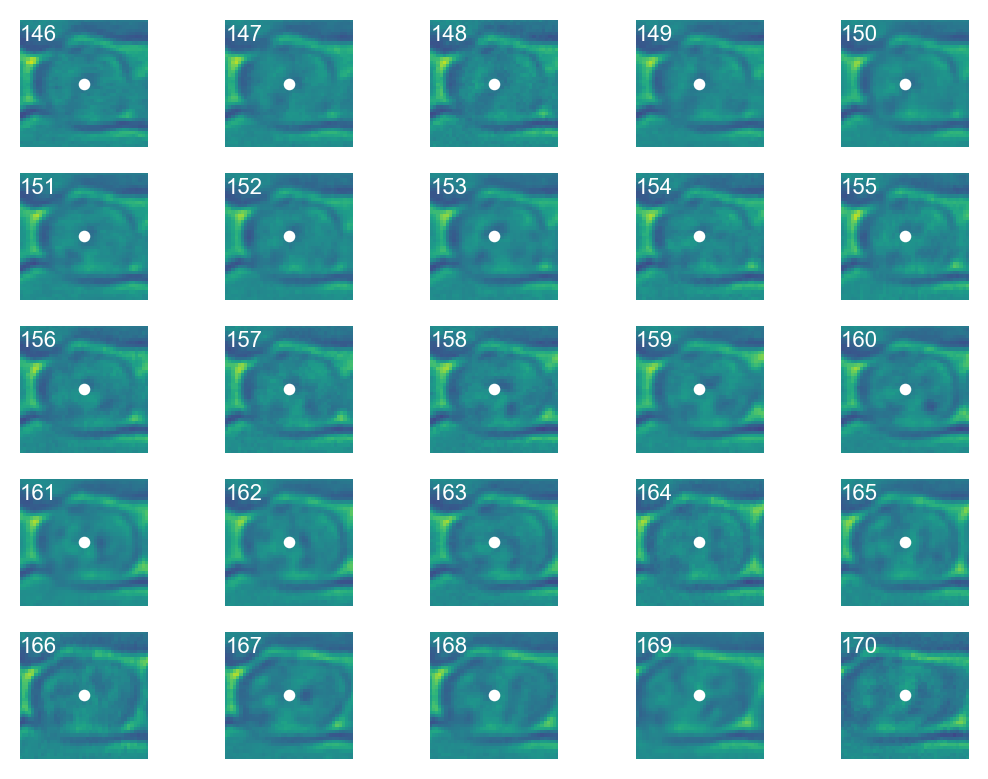

In [67]:
celldf = crop_rois_df

fig = plt.figure()
fig.set_dpi(200)

no_axes = True
xvar = 'x_center'
yvar = 'y_center'
nrows = 5
ncols = 5
total = nrows*ncols
markersize = 10
markercolor = 'white'
fontcolor = 'white'
axis_buffer = 20

for idx in range(0, total):
    ax_idx = idx + 1
    ax = fig.add_subplot(nrows, ncols, ax_idx)
    frame_number = int(idx+celldf.frame.min())
    ax.imshow(bf_stack[frame_number])
    x = celldf.loc[celldf.frame_rel==idx, xvar].iloc[0]
    y = celldf.loc[celldf.frame_rel==idx, yvar].iloc[0]
    ax.scatter(x, y, color=markercolor, s=markersize)
    # Formatting stuff
    xlim = (x-axis_buffer, x+axis_buffer)
    ylim = (y-axis_buffer, y+axis_buffer)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    xy = (np.min(xlim), np.max(ylim)*0.98)
    ax.annotate(frame_number, xy=xy, color=fontcolor, fontsize=8)
    
    if no_axes:
        plt.axis('off')

### Make a cropped stack using cell center point

In [74]:
cellroidf = segmentation.fill_crop_roi_df(0, mdf, bf_stack=bf_stack)

bf_stack = skimage.io.imread(bf_stack_path)

In [149]:
reload(segmentation)

<module 'byc.segmentation' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\segmentation.py'>

In [150]:
save_stack = False

cellstack, cellroidf = segmentation.cropped_stack_from_cellroidf(cellroidf,
                                                      bf_stack)

crop_rois_path = cellroidf.crop_roi_set_path.iloc[0]
compartment_name = cellroidf.compartment_name.iloc[0]
auto_compartment_name = f'{compartment_name}_auto'
crop_rois_path_mod = crop_rois_path.replace(compartment_name, auto_compartment_name)
stack_path = crop_rois_path_mod.replace('crop_rois.zip', 'crop.tif')

if save_stack:
    arr = np.array(cellstack)
    skimage.io.imsave(stack_path, arr)

### If it exists, add fluoresnce intensity information from corresponding `trace_df`

This is an important step for validating automated fluorescence measurements against manual ones down the road

### Measure average intensity along circular slices of varying distance from the center of the ROI

In [147]:
reload(segmentation)

<module 'byc.segmentation' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\segmentation.py'>

In [193]:
frame_idx = 0
x_center_rel = cellroidf.x_center_rel[frame_idx]
y_center_rel = cellroidf.y_center_rel[frame_idx]
rad, intensity = radial_avg_intensity(cellstack[frame_idx],
                                      x_center_rel,
                                      y_center_rel)


peaks = find_peaks(intensity, height=np.array([300, None]))
print(peaks)
peak_radius = peaks[0][0]
print(peak_radius)

(array([ 5,  9, 17, 25, 27, 31, 41, 45], dtype=int64), {'peak_heights': array([1907.8125    , 1886.70833333, 1989.40625   , 1895.78888889,
       1915.60240964, 1928.23837209, 2012.7804878 , 2106.62025316])})
5


### Plot average intensity against radial distance from the center of the above cell

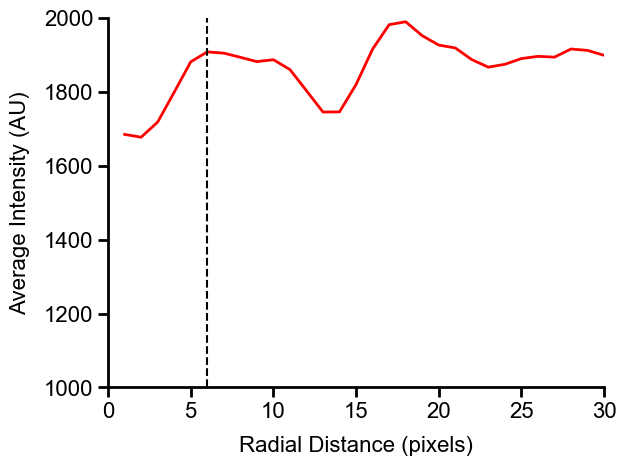

In [194]:
mpl = matplotlib
max_distance = 30
# Adjust plot parameters
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
# Create figure and add subplot
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot data
ax.plot(rad, intensity, linewidth=2, color='red')
# Edit axis labels
ax.set_xlabel('Radial Distance (pixels)', labelpad=10)
ax.set_ylabel('Average Intensity (AU)', labelpad=10)
ax.set_xlim(0, max_distance)
ax.set_ylim(1000, 2000)
intensity_slice = intensity[0:max_distance+1]
intensity_slice = intensity_slice - intensity_slice.min()
# peaks[0] is the index at which the peak is found. 
# So index + 1 = actual distance
ax.axvline(x=peak_radius+1, color='black', linestyle='--')

In [197]:
intensity_mean_cent = intensity/intensity.mean()

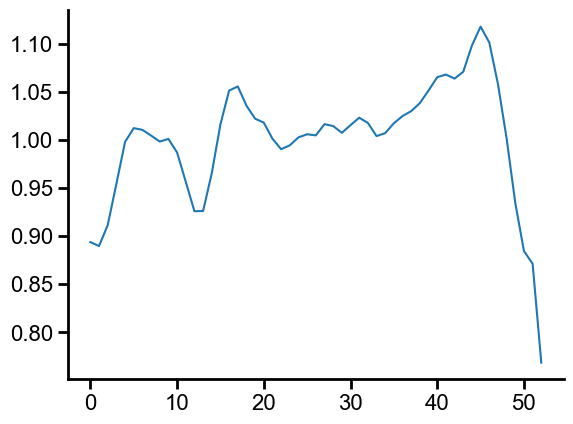

In [198]:
plt.plot(intensity_mean_cent)

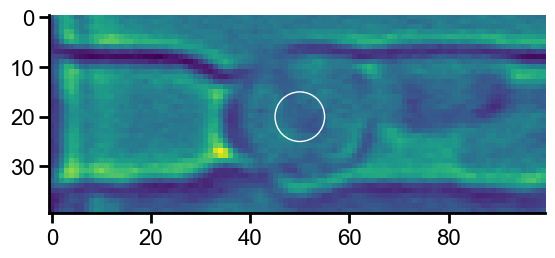

In [184]:
ax = plt.axes()

ax.imshow(cellstack[frame_idx])
x_center_rel = cellroidf.x_center_rel.iloc[frame_idx]
y_center_rel = cellroidf.y_center_rel.iloc[frame_idx]
circ = mpl.patches.Circle(xy=(x_center_rel, y_center_rel), radius=peak_radius,
                          color='white', fill=False)
ax.add_patch(circ)

**Super helpful! A normal cell width is around 25 px and that first peak is right around 12 px**

(1000.0, 1600.0)

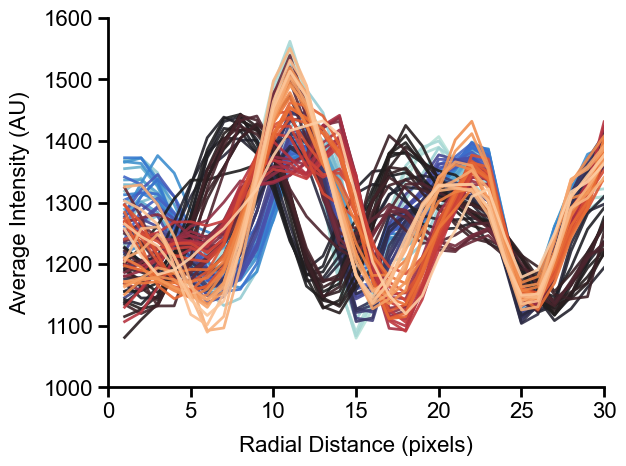

In [16]:
mpl = matplotlib
max_distance = 30
palette = sns.color_palette("icefire", n_colors=90)
# Adjust plot parameters
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
# Create figure and add subplot
fig = plt.figure()
ax = fig.add_subplot(111)
for i, intensity in enumerate(intensities):
    # Plot data
    rad = radial_dists[i]
    ax.plot(rad, intensity, linewidth=2, color=palette[i],
            alpha=0.9)
    # Edit axis labels
    ax.set_xlabel('Radial Distance (pixels)', labelpad=10)
    ax.set_ylabel('Average Intensity (AU)', labelpad=10)
    ax.set_xlim(0, max_distance)
    
ax.set_ylim(1000, 1600)

### Plot a circle with radius at first peak found above

Text(0.5, 0, 'X Distance (pixels)')

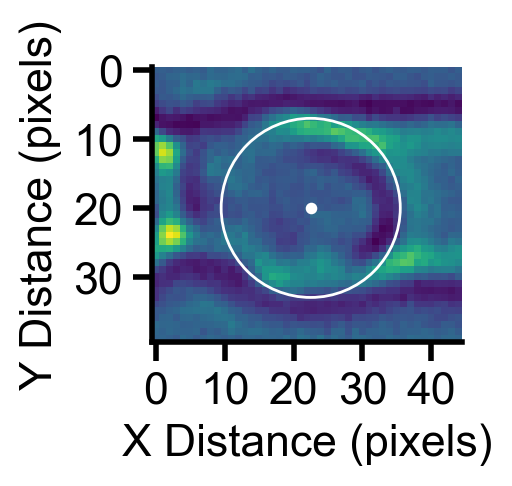

In [17]:
frame = 0
fig = plt.figure(figsize=(2, 2))
fig.set_dpi(200)
ax = plt.axes()
img = bf_stack[frame]
cellcrop = img[y_lower:y_upper, x_lower:x_upper]
ax.imshow(cellcrop);

x_center_rel = x_center - x_lower
y_center_rel = y_center - y_lower
ax.scatter(x_center_rel, y_center_rel, s=10,
           color='white')
circ = mpl.patches.Circle(xy=(x_center_rel, y_center_rel), radius=radius,
                          color='white', fill=False)
ax.add_patch(circ)
ax.set_xticks(np.array(range(0, cellcrop.shape[1], 10)))
ax.set_yticks(np.array(range(0, cellcrop.shape[0], 10)))
ax.set_ylabel('Y Distance (pixels)')
ax.set_xlabel('X Distance (pixels)')

### Creating polar coordinates to use in measuring intensity along rays drawn out from center

First, for each pixel in the image, create a 2 x N (N = # of pixels in image) of cartesian coordinates for that pixel relative to an arbitrary center point. Calcuate radial coordinate using pythagorean theoreom and theta = arctan(Y/X) for angular coordinate

In [204]:
segmentation.get_polar_coordinates?

In [206]:
from byc import segmentation
reload(segmentation)
cellcrop = cellstack[frame_idx]
R, theta = segmentation.get_polar_coordinates(cellcrop, x_center_rel, y_center_rel)

### Select angular slice of image using polar coordinates calculated above

Text(0.5, 1.0, '0 to 0.79 radians blacked out')

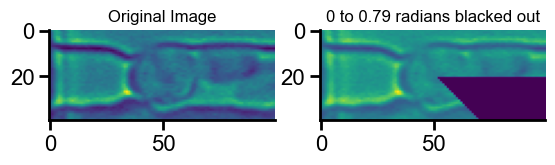

In [207]:
bin_size = np.pi/4
i = 0
min_theta = 0
max_theta = i + bin_size
mask = (np.greater(theta, min_theta) & np.less(theta, max_theta))
values = cellcrop[mask]
cellcrop_sliced = cellcrop.copy()
cellcrop_sliced[mask] = 0

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(cellcrop)
ax2 = fig.add_subplot(122)
ax2.imshow(cellcrop_sliced)
# Titles
ax.set_title(f'Original Image', fontsize=12)
ax2.set_title(f'{round(min_theta, 2)} to {round(max_theta, 2)} radians blacked out',
              fontsize=12)

Calculate the mean intensity of all pixels within each theta and radial distance bin

In [208]:
reload(segmentation)
df = segmentation.intensity_by_distance_and_theta(cellcrop, x_center_rel, y_center_rel)

C:\.byc\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\.byc\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


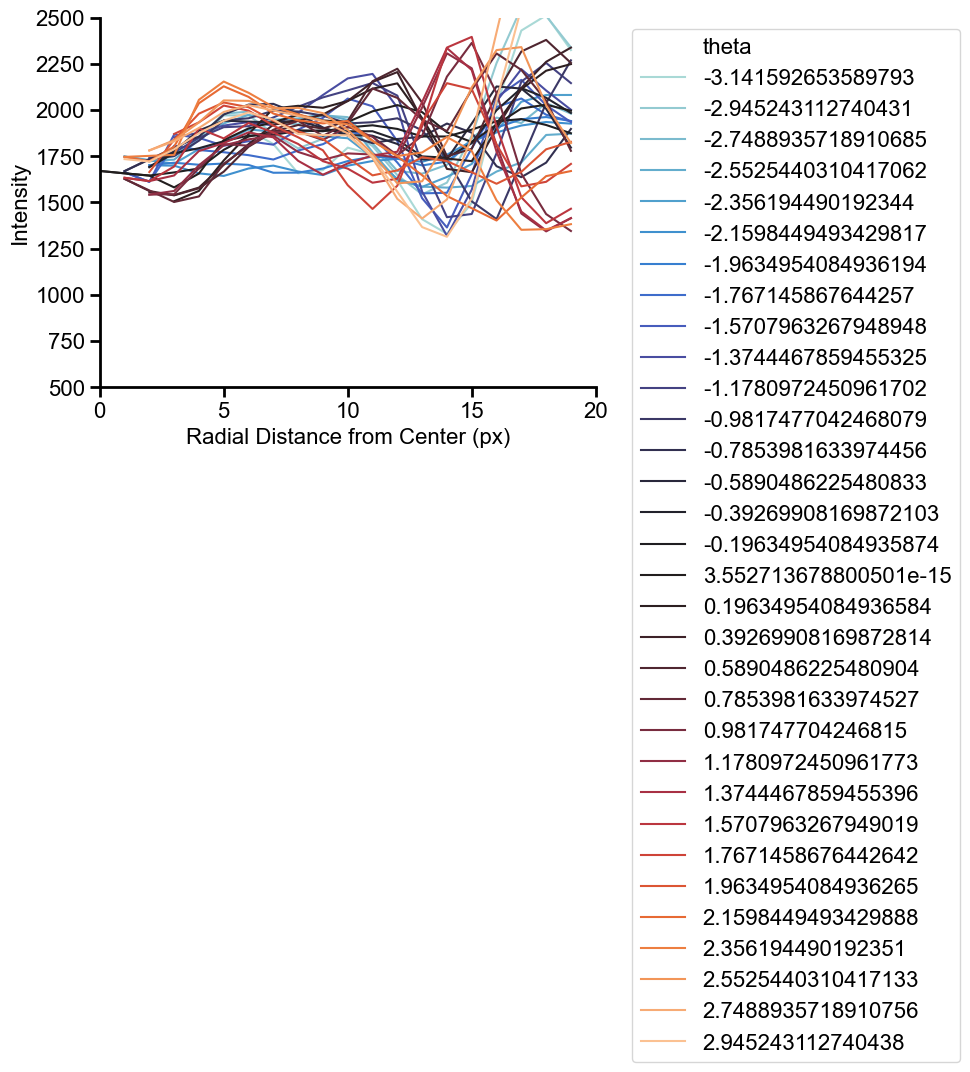

In [209]:
palette = sns.color_palette("icefire", n_colors=len(df.theta.unique()))
fig = plt.figure()

ax = sns.lineplot(x='radial_distance', y='intensity', hue='theta', data=df,
             hue_order=df.theta.unique(), palette=palette)
ax.set_xlim(0, 20)
ax.set_ylim(500, 2500)
ax.set_ylabel('Intensity', fontsize=16)
ax.set_xlabel('Radial Distance from Center (px)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

### Finding and annotating peaks

In [210]:
df = segmentation.polar_intensity_peaks(df)

table = df.pivot_table(index='theta', aggfunc='mean').reset_index()
table.loc[:, 'peak_X'] = table.highest_peak_dist*np.cos(table.theta) + x_center_rel
table.loc[:, 'peak_Y'] = table.highest_peak_dist*np.sin(table.theta) + y_center_rel

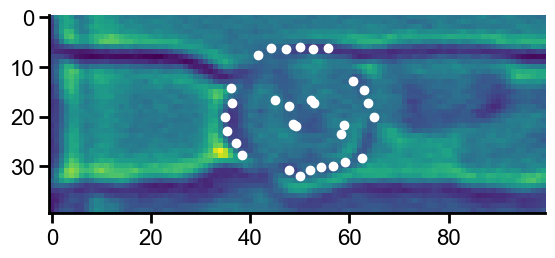

In [211]:
ax = plt.axes()
ax.imshow(cellcrop)
ax.scatter(table.peak_X, table.peak_Y, color='white')

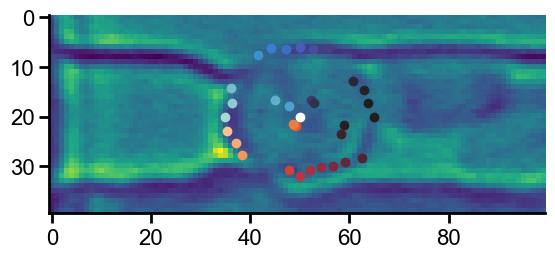

In [212]:
ax = plt.axes()
ax.imshow(cellcrop)
i=0
for index in table.index:
    c = palette[i]
    x = table.loc[index, 'peak_X']
    y = table.loc[index, 'peak_Y']
    ax.scatter(x, y, color=c)
    i+=1
ax.scatter(x_center_rel, y_center_rel, color='white')

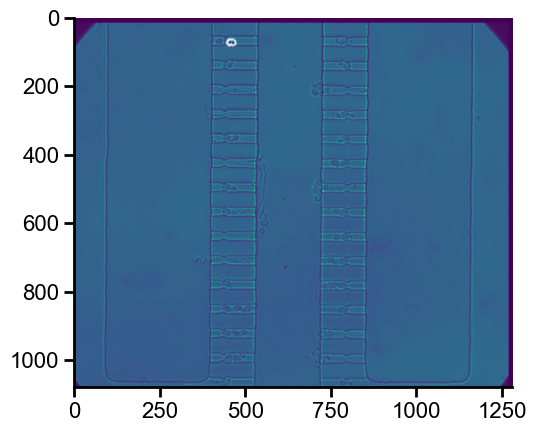

In [365]:
table.loc[:, 'peak_X'] = table.highest_peak_dist*np.cos(table.theta) + x_center
table.loc[:, 'peak_Y'] = table.highest_peak_dist*np.sin(table.theta) + y_center

ax = plt.axes()
ax.imshow(img)
ax.scatter(table.peak_X, table.peak_Y,
           color='white', s=0.1)

## Finding radial intensity peaks in a cell stack

In [8]:
import os
import re
import shutil

from importlib import reload

import numpy as np
import pandas as pd
import skimage
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

import tifffile
from read_roi import read_roi_file, read_roi_zip

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import process, registration, constants, trace_tools, fitting_tools, segmentation
from byc import files
from byc import standard_analysis as sa
from byc.segmentation import radial_avg_intensity
for mod in [process, registration, constants,
            trace_tools, fitting_tools, sa,
            files]:
    reload(mod)

In [108]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)
rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

# hard coded cell crop ROI details
cell_index = 3
compartment_dir = wt_ds.master_index_df.compartment_dir.iloc[cell_index]
rois_fn = "20210126_byc_cell003_crop_rois.zip"
rois_path = os.path.join(compartment_dir, rois_fn)
# Read the ROI and the original brightfield FOV stack
bf_stack_path = wt_ds.master_index_df.active_imp_path.iloc[cell_index]
stack_path = bf_stack_path.replace('_bf_', '_rfp_')
bf_stack = skimage.io.imread(stack_path)

rois_df = files.read_rectangular_rois_as_df(rois_path)

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell001_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell001_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\2021

Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell004_crop_rois.zip
Found data for cell 4 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell004_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell004_crop_rois.zip
Found data for cell 5 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell005_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell005_crop_rois.zip
Found data for cell 5 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell005_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_

In [102]:
theta_bin_size = np.pi/4
peaks_dfs = []
cellcrops = []
for frame_index, frame in enumerate(bf_stack):
    position = frame_index + 1
    print(f'Looking for cell edges in frame position {position} of {len(bf_stack)}')
    # Find which roi to use
    for index in rois_df.index:
        row = rois_df.loc[index, :]
        positions = np.arange(row.position, row.position_max+1, 1)
        if position in positions:
            good_index = index
    frame_roi_row = rois_df.loc[good_index, :]    
    x_lower = frame_roi_row.left
    x_upper = x_lower + frame_roi_row.width
    x_center = x_lower + frame_roi_row.width/2
    y_lower = frame_roi_row.top
    y_center = y_lower + frame_roi_row.height/2
    y_upper = y_lower + frame_roi_row.height
    # Center of cell within cropped frame
    cellcrop = frame[y_lower:y_upper, x_lower:x_upper]
    cellcrops.append(cellcrop)
    x_center_rel = x_center - x_lower
    y_center_rel = y_center - y_lower
    polar_I_df = segmentation.intensity_by_distance_and_theta(cellcrop,
                                                              x_center_rel,
                                                              y_center_rel,
                                                              theta_bin_size=theta_bin_size)
    peaks_df = segmentation.polar_intensity_peaks(polar_I_df)
    peaks_df.loc[:, 'frame_index'] = frame_index
    peaks_dfs.append(peaks_df)

Looking for cell edges in frame position 1 of 90
No peaks found at -1.5707963267948966 radians
No peaks found at 1.5707963267948966 radians
Looking for cell edges in frame position 2 of 90


C:\.byc\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\.byc\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Looking for cell edges in frame position 3 of 90
Looking for cell edges in frame position 4 of 90
Looking for cell edges in frame position 5 of 90
Looking for cell edges in frame position 6 of 90
Looking for cell edges in frame position 7 of 90
No peaks found at 0.7853981633974483 radians
No peaks found at 1.5707963267948966 radians
Looking for cell edges in frame position 8 of 90
No peaks found at -1.5707963267948966 radians
Looking for cell edges in frame position 9 of 90
Looking for cell edges in frame position 10 of 90
Looking for cell edges in frame position 11 of 90
Looking for cell edges in frame position 12 of 90
Looking for cell edges in frame position 13 of 90
Looking for cell edges in frame position 14 of 90
Looking for cell edges in frame position 15 of 90
No peaks found at 2.356194490192345 radians
Looking for cell edges in frame position 16 of 90
Looking for cell edges in frame position 17 of 90
No peaks found at 0.7853981633974483 radians
Looking for cell edges in frame 

In [111]:
allpeaks = pd.concat(peaks_dfs, ignore_index=True)
# Get rid of intensity vs. radial distance data
# by aggregating by frame_index and theta
allpeaks_table = allpeaks.pivot_table(index=['frame_index', 'theta'], aggfunc='mean').reset_index()
allpeaks_table.head()

frame_index     theta  first_peak_dist  highest_peak_dist   intensity  \
0            0 -3.141593              3.0               -1.0  374.086804   
1            0 -2.356194              5.0                1.0  382.207028   
2            0 -1.570796              NaN                NaN  397.867210   
3            0 -0.785398              3.0                2.0  434.945442   
4            0  0.000000              4.0                2.0  437.049371   

      peak_X     peak_Y  radial_distance  x_center  y_center  
0  15.500000  20.500000              9.5      18.5      20.5  
1  14.964466  16.964466              9.5      18.5      20.5  
2        NaN        NaN              9.5      18.5      20.5  
3  22.742641  16.257359              9.5      18.5      20.5  
4  24.500000  20.500000              9.5      18.5      20.5

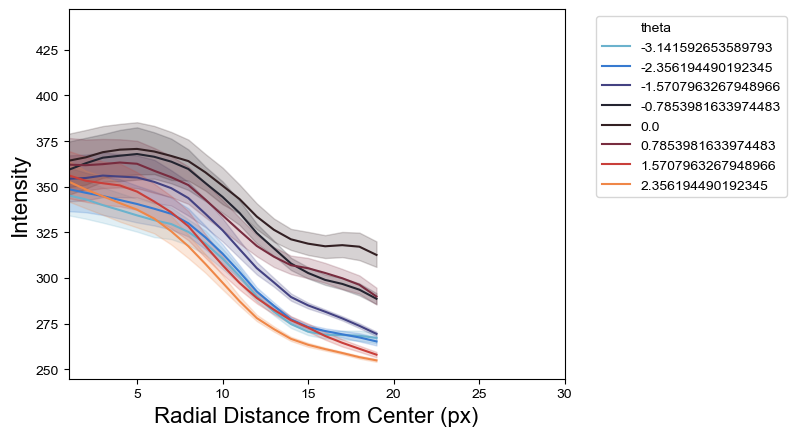

In [114]:
palette = sns.color_palette("icefire", n_colors=len(allpeaks.theta.unique()))
fig = plt.figure()

ax = sns.lineplot(x='radial_distance', y='intensity', hue='theta', data=allpeaks,
             hue_order=df.theta.unique(), palette=palette)
ax.set_xlim(1, 30)
# ax.set_ylim(500, 2500)
ax.set_ylabel('Intensity', fontsize=16)
ax.set_xlabel('Radial Distance from Center (px)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

<Figure size 640x480 with 0 Axes>

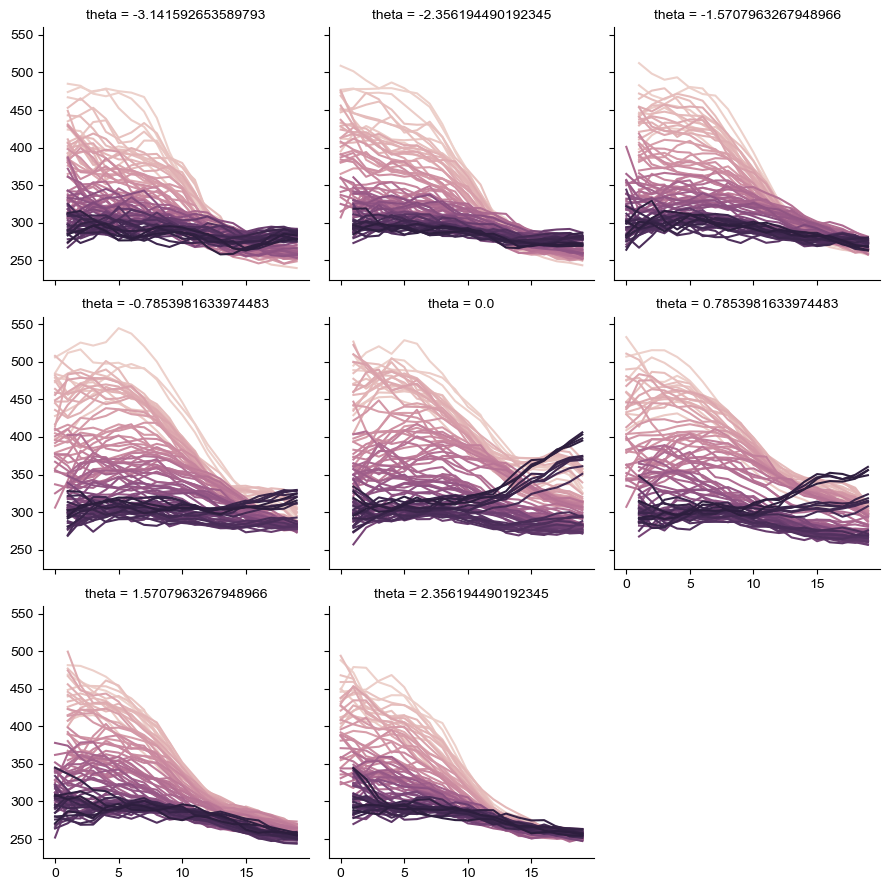

In [118]:
palette = sns.color_palette("icefire", n_colors=len(allpeaks.theta.unique()))
fig = plt.figure()

g = sns.FacetGrid(allpeaks, col='theta', col_wrap=3)
g.map_dataframe(sns.lineplot, x='radial_distance', y='intensity',
                hue='frame_index')
# ax.set_ylim(500, 2500)
# ax.set_ylabel('Intensity', fontsize=16)
# ax.set_xlabel('Radial Distance from Center (px)', fontsize=16)

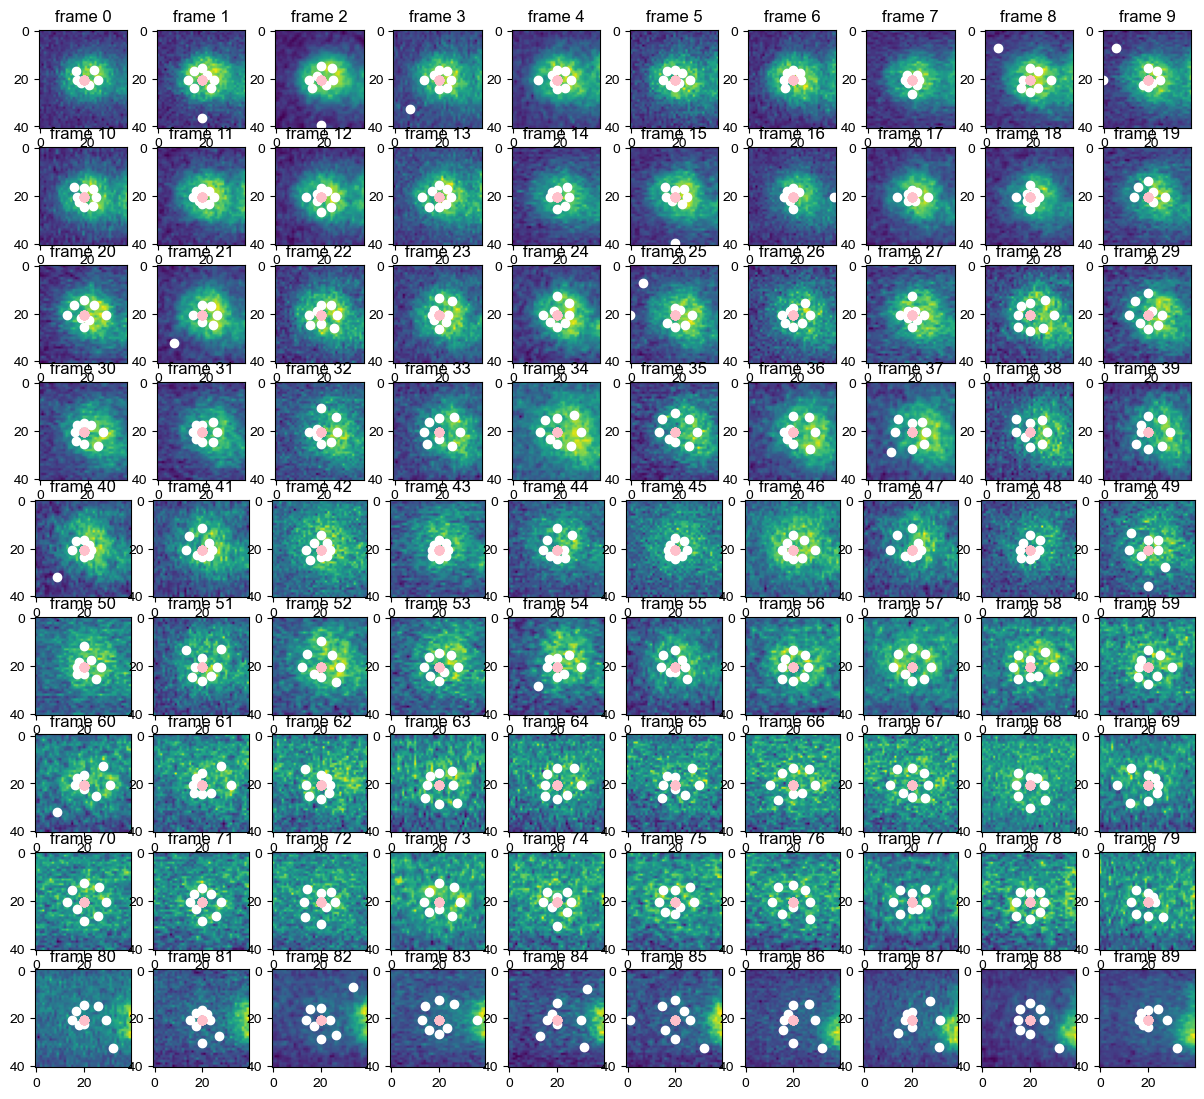

In [113]:
fig = plt.figure(figsize=(15, 15))
for i, df in enumerate(peaks_dfs):
    table = df.pivot_table(index='theta', aggfunc='mean').reset_index()
    
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(cellcrops[i])
    ax.scatter(table.peak_X, table.peak_Y, color='white')
    ax.scatter(table.x_center, table.y_center, color='pink')
    ax.set_title(f'frame {i}')

Looking for outliers in distance from annotated "center"

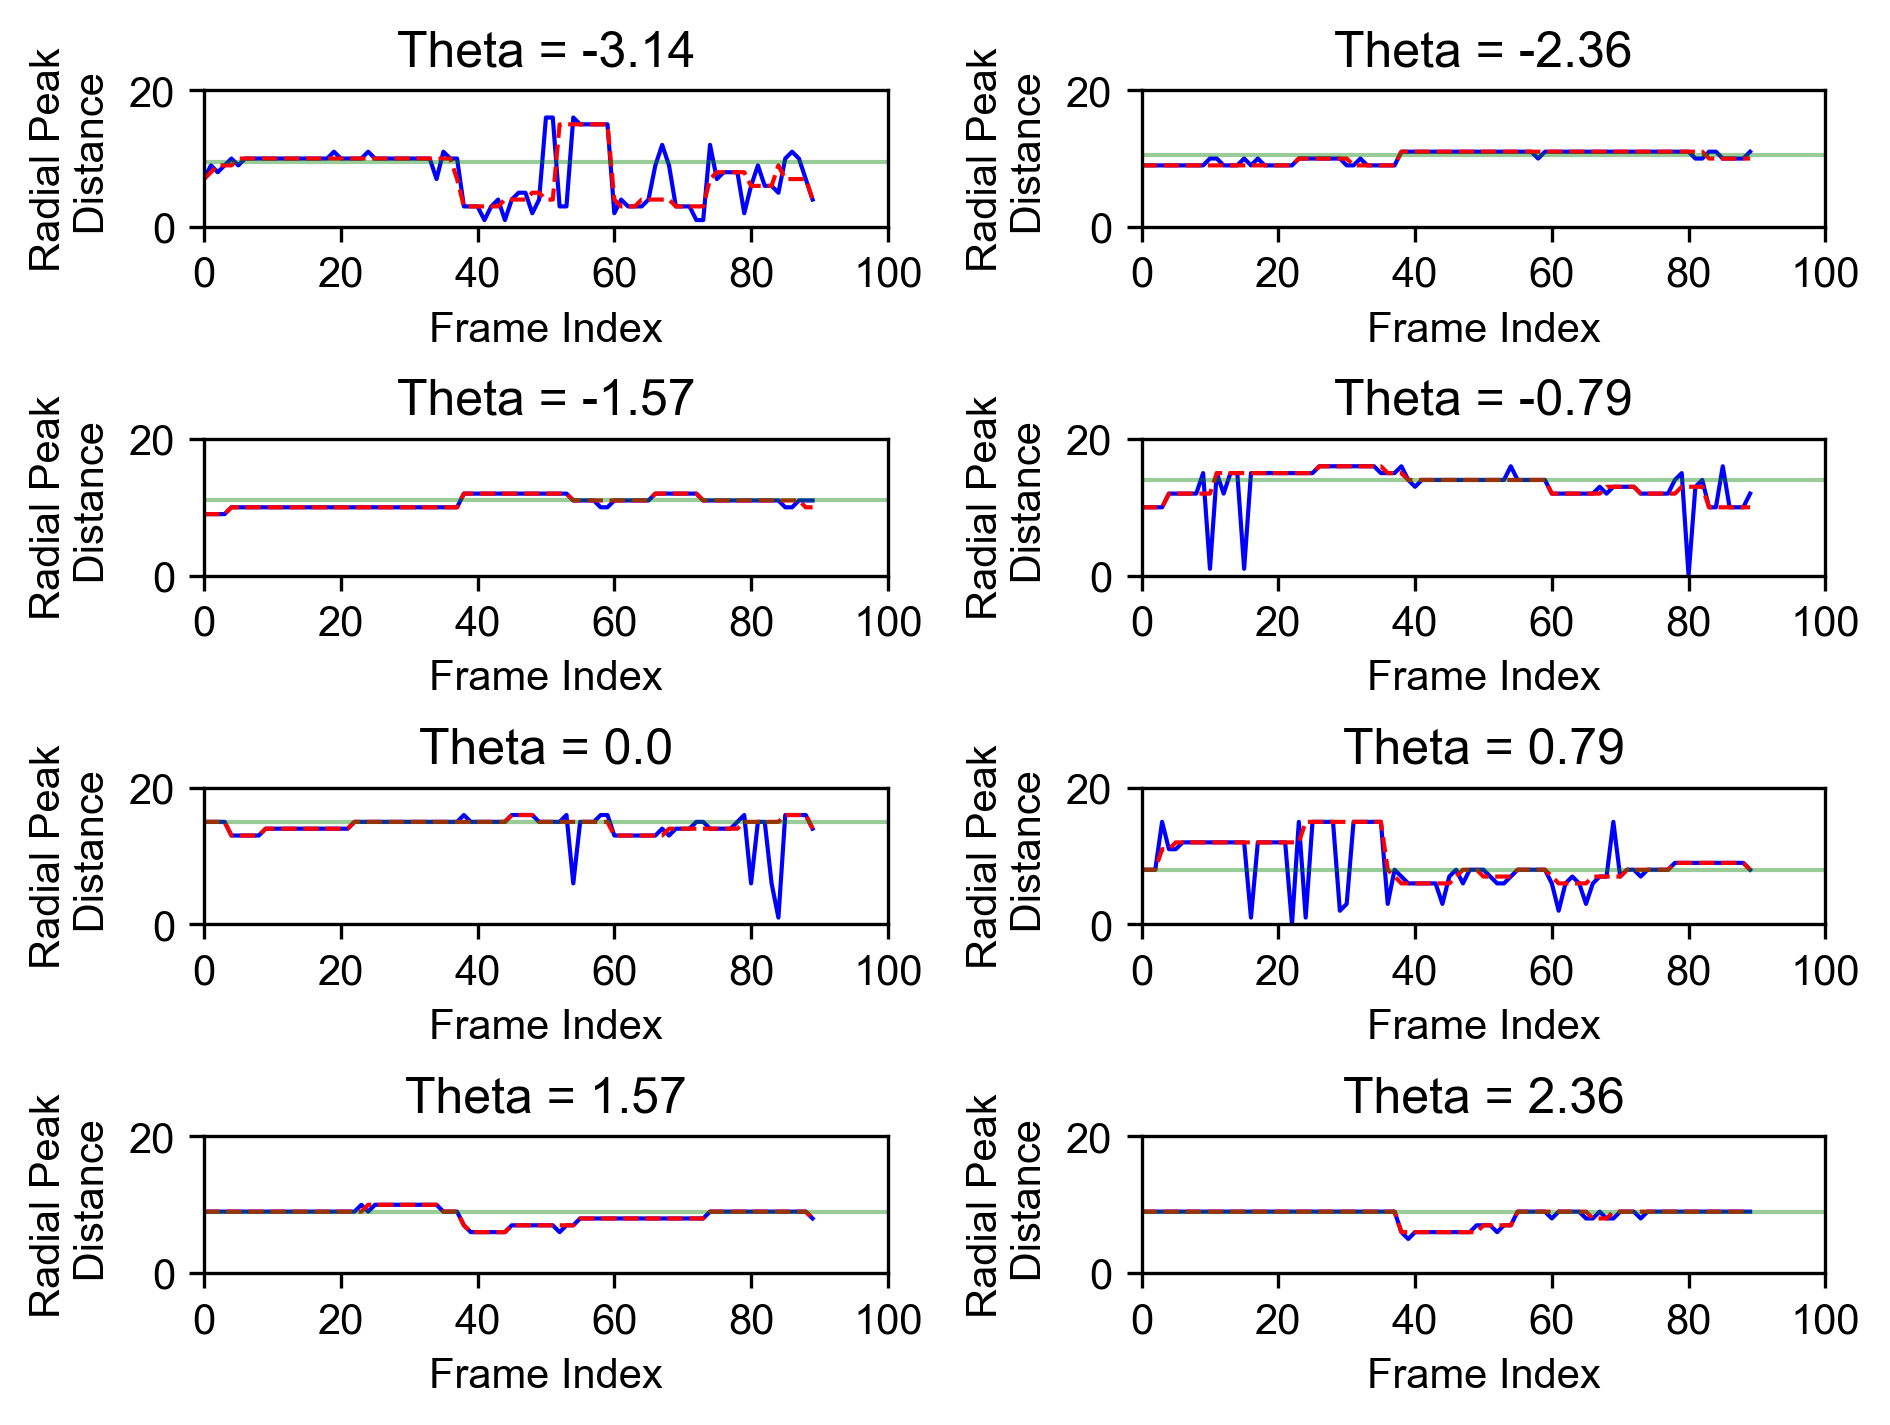

In [54]:
# theta = allpeaks.theta[30]
# df = allpeaks_table.loc[allpeaks_table.theta == theta]
kern_size = 7
n = len(allpeaks_table.theta.unique())
figsize=(5, 5)
ylim=(0, 20)
xlim=(0, 100)
fig, axs = plt.subplots(4, 2)
axs = axs.reshape(axs.shape[0]*axs.shape[1])
fig.set_dpi(300)
i=0
for theta in allpeaks_table.theta.unique():
    
    df = allpeaks_table.loc[allpeaks_table.theta==theta]
    x = df.frame_index
    y = df.highest_peak_dist
    medfilt_y = medfilt(y, kernel_size=kern_size)
    ax = axs[i]
    ax.plot(x, y, color='blue', linewidth=1)
    ax.plot(x, medfilt_y, color='red', linestyle='--', linewidth=1)
    ax.axhline(np.median(y), color='green', alpha=0.4, linewidth=1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_aspect('equal')
#     ax.annotate(f'Theta = {np.round(theta, 2)}', (xlim[0] + 0.05*xlim[1],
#                                                   ylim[0]+0.10*abs(ylim[1])))
    ax.set_title(f'Theta = {np.round(theta, 2)}')
    ax.set_ylabel('Radial Peak\n Distance')
    ax.set_xlabel('Frame Index')
    i += 1
fig.tight_layout()

Filter out medfilt residual outliers

In [47]:
# theta = allpeaks.theta[30]
# df = allpeaks_table.loc[allpeaks_table.theta == theta]
kern_size = 21
factor = 3.5
n = len(allpeaks_table.theta.unique())
dataframe = allpeaks_table
dataframe.loc[:, 'peak_dist_outliers_filtered'] = np.nan
outlier = False
# Find outliers in median filtered
# peak distances from 'center' within
# theta groups
for theta in dataframe.theta.unique():    
    mask = dataframe.theta==theta
    x = dataframe[mask].frame_index
    y = dataframe[mask].highest_peak_dist
    medfilt_y = medfilt(y, kernel_size=kern_size)
    dataframe.loc[mask, 'highest_peak_dist_medfilt'] = medfilt_y
    medfilt_resid = y - medfilt_y
    dataframe.loc[mask, 'medfilt_resid'] = medfilt_resid
    # Find outliers
    adj_resids = medfilt_resid + np.abs(np.min(medfilt_resid))
    std = np.std(adj_resids)
    mean = np.mean(adj_resids)
    out_mask = np.logical_or(adj_resids > mean+factor*std, adj_resids < mean-factor*std)
    # Create filtered peaks data
    clean_y = y
    # Replace outliers with median_filtered peak dist
    # at their coordinate. Median filter again, then use
    # that value in the final peak
    clean_y[out_mask] = medfilt_y[out_mask]
    filt_clean_y = medfilt(clean_y)
    final_y = y
    final_y[out_mask] = filt_clean_y[out_mask]
    dataframe.loc[mask, 'clean_peak_dist'] = final_y
    dataframe.loc[mask, 'clean_peak_X'] = final_y*np.cos(theta) + dataframe[mask].x_center
    dataframe.loc[mask, 'clean_peak_Y'] = final_y*np.sin(theta) + dataframe[mask].y_center

<ipython-input-47-0fff79ef37c4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_y[out_mask] = filt_clean_y[out_mask]


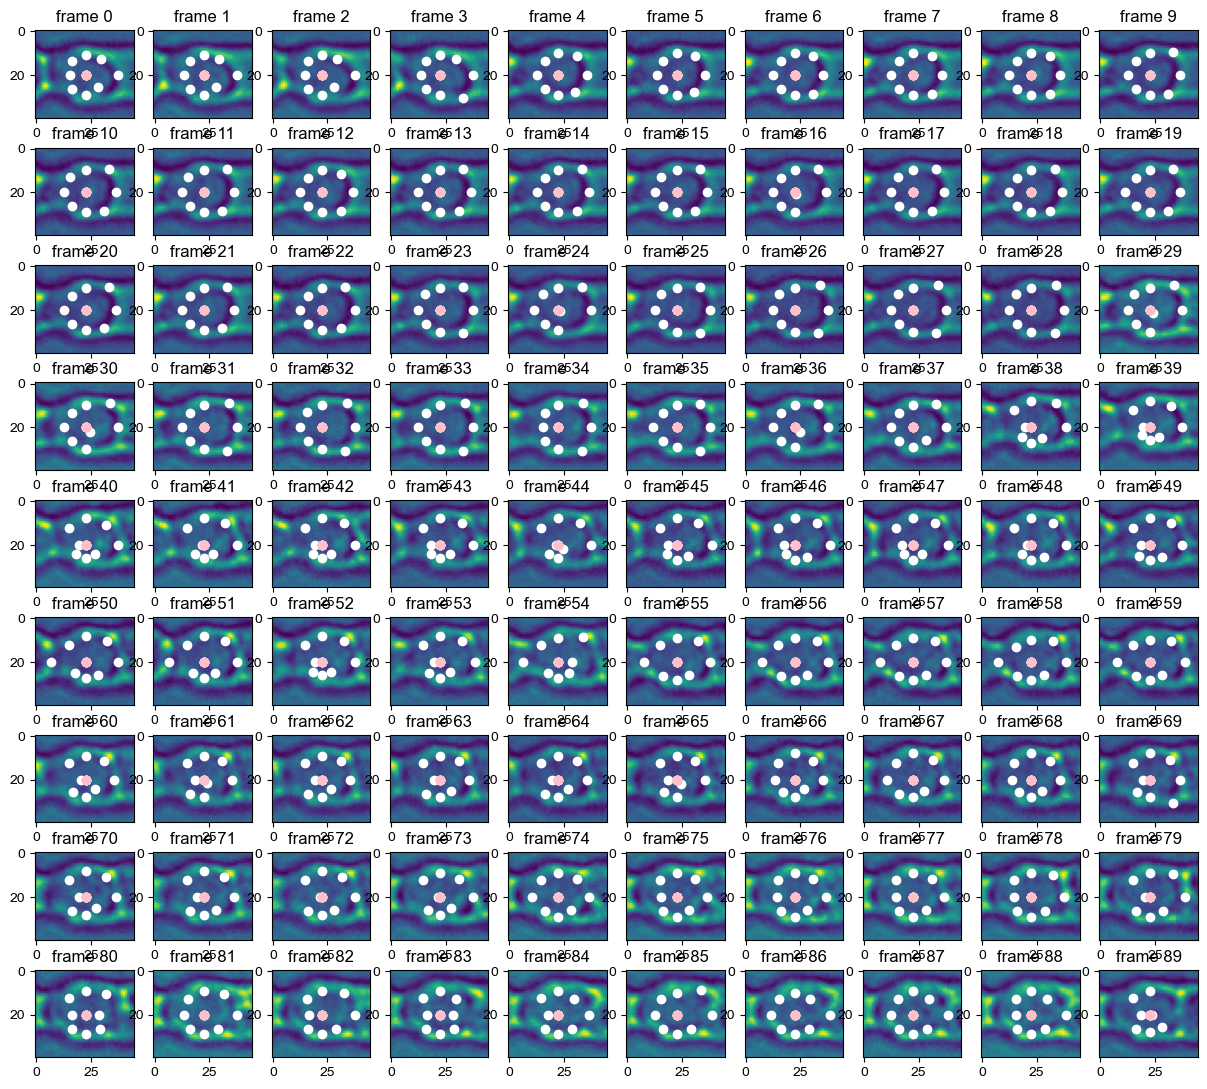

In [18]:
fig = plt.figure(figsize=(15, 15))

for i in dataframe.frame_index.unique():
    table = dataframe[dataframe.frame_index==i].pivot_table(index='theta', aggfunc='mean').reset_index()
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(cellcrops[i])
    ax.scatter(table.clean_peak_X, table.clean_peak_Y, color='white')
    ax.scatter(table.x_center, table.y_center, color='pink')
    ax.set_title(f'frame {i}')

Filter outliers from mean of whole theta groups. Replace not with medfilt value but with median for that theta

In [70]:
len(df.index.unique())

8

In [74]:
fig.add_subplot?

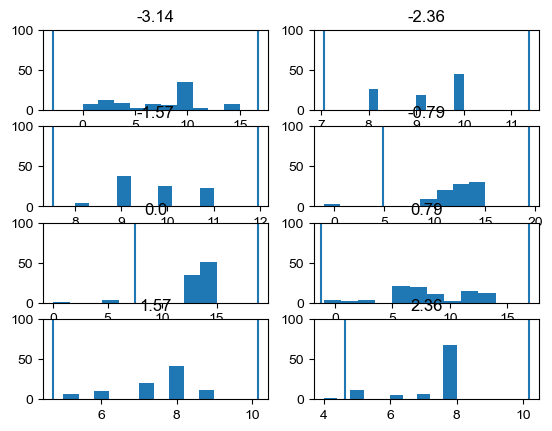

In [80]:
cutoff_sds = 2.5
df = allpeaks_table.set_index('theta')
df.loc[:, 'highest_peak_dist_filt'] = np.nan
i = 0
fig = plt.figure()
for theta in df.index.unique():
    peak_dists = df.loc[theta, 'highest_peak_dist']
    mean = np.mean(peak_dists)
    std = np.std(peak_dists)
    upper = mean + cutoff_sds*std
    lower = mean - cutoff_sds*std
    outlier_mask = np.logical_or(peak_dists > upper, peak_dists < lower)
    ax = fig.add_subplot(4, 2, i+1)    
    ax.hist(df.loc[theta, 'highest_peak_dist'])
    ax.set_title(round(theta, 2))
    ax.set_ylim(0, 100)
    ax.axvline(upper)
    ax.axvline(lower)
    i+=1

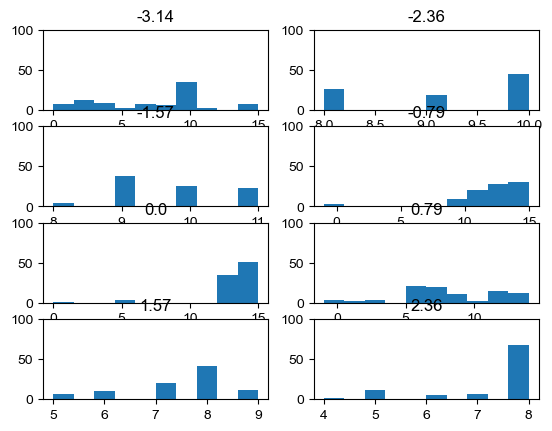

In [76]:
df = allpeaks_table.set_index('theta')

fig = plt.figure()
i = 0
for theta in df.index.unique():
    ax = fig.add_subplot(4, 2, i+1)    
    ax.hist(df.loc[theta, 'highest_peak_dist'])
    ax.set_title(round(theta, 2))
    ax.set_ylim(0, 100)
    i += 1


In [ ]:
np.mean()

In [558]:
dataframe.medfilt_resid.unique()

array([  0.,   9.,   2.,   1.,  -1.,   4.,   3., -11.,  -3., -14., -12.,
       -10.,  -9.,   7.,   8.,  -4.,  -2.,  12.,  11.,  10.,   6.,  -7.,
        -5.,   5.,  -8., -13.,  13.])

In [555]:
outlier_mask

7      True
15     True
23     True
31     True
39     True
       ... 
687    True
695    True
703    True
711    True
719    True
Name: medfilt_resid, Length: 90, dtype: bool

In [531]:
allpeaks_table.

frame_index     theta  first_peak_dist  highest_peak_dist    intensity  \
0              0 -3.141593              3.0                7.0  1270.699691   
1              0 -2.356194              6.0                9.0  1249.007619   
2              0 -1.570796              5.0                9.0  1261.595780   
3              0 -0.785398              5.0               10.0  1326.026161   
4              0  0.000000              3.0               15.0  1328.000286   
..           ...       ...              ...                ...          ...   
715           89 -0.785398              8.0               12.0  1276.792171   
716           89  0.000000              9.0               14.0  1297.036331   
717           89  0.785398             11.0                8.0  1278.041264   
718           89  1.570796              3.0                8.0  1308.003847   
719           89  2.356194             12.0                9.0  1297.513529   

        peak_X     peak_Y  radial_distance  x_center  y_center  \
0    12.500000  20.000000              9.5      22.5      20.0   
1    14.014719  11.514719              9.5      22.5      20.0   
2    22.500000   8.000000              9.5      22.5      20.0   
3    31.692388  10.807612              9.5      22.5      20.0   
4    40.500000  20.000000              9.5      22.5      20.0   
..         ...        ...              ...       ...       ...   
715  33.106602   9.393398              9.5      22.5      20.0   
716  39.500000  20.000000              9.5      22.5      20.0   
717  30.278175  27.778175              9.5      22.5      20.0   
718  22.500000  31.000000              9.5      22.5      20.0   
719  14.014719  28.485281              9.5      22.5      20.0   

     highest_peak_dist_medfilt  
0                          7.0  
1                          9.0  
2                          9.0  
3                          1.0  
4                         13.0  
..                         ...  
715                        0.0  
716                        1.0  
717                        8.0  
718                        8.0  
719                        9.0  

[720 rows x 11 columns]

In [385]:
def ellipse_polar(theta, a, b):
    """
    Return r (radial distance) as a function of the
    constants a and b (two radii?) and theta, rotation
    around a center
    """
    r = a*b/(np.sqrt(np.power(b*np.cos(theta), 2) + np.power(a*np.sin(theta), 2)))
    return r

In [386]:
t = np.arange(-np.pi, np.pi, theta_bin_size)

In [387]:
subdf = allpeaks.loc[allpeaks.frame_index==53]
frame_table = subdf.pivot_table(index='theta', aggfunc='mean').reset_index()

In [388]:
from scipy.optimize import curve_fit

In [390]:
x = frame_table.theta
y = frame_table.highest_peak_dist
popt, pcov = curve_fit(ellipse_polar, x, y)

In [391]:
new_X = frame_table.peak_X - x_naught
new_Y = frame_table.peak_Y - y_naught
new_dists = np.sqrt(new_X**2 + new_Y**2)

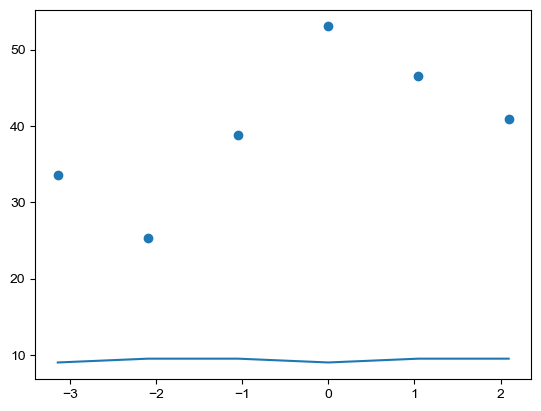

In [392]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(frame_table.theta, new_dists)
ax.plot(t, ellipse(t, a=popt[0], b=popt[1]))

### Fitting ellipse 
[Stack overflow solution](https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points)

The ellipse is given by -0.000991x^2 + -0.000289xy+-0.00117y^2+0.0586x+0.0466y = 1


<ipython-input-393-bac8fc7bdd3b>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()


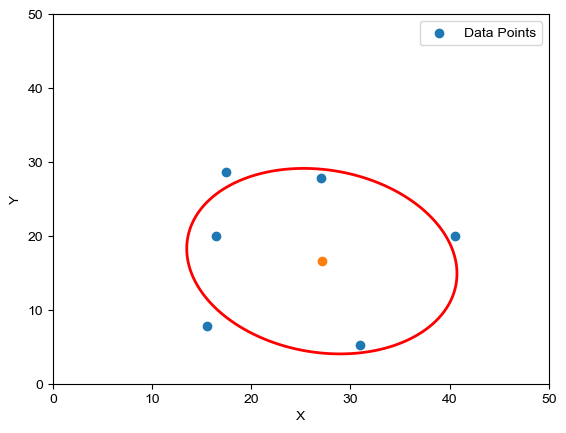

In [393]:
X = np.array(frame_table.peak_X)
X = X.reshape(len(X), 1)
Y = np.array(frame_table.peak_Y)
Y = Y.reshape((len(Y), 1))
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()
# Using the general form of an ellipse from wikipedia
A, B, C, D, E = x[0], x[1], x[2], x[3], x[4]
F=-1
a = -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C)+np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C)
b = -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F)*((A+C)-np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C)
x_naught = (2*C*D - B*E)/(B**2 - 4*A*C)
y_naught = (2*A*E - B*D)/(B**2 - 4*A*C)
# Print the equation of the ellipse in standard form
print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

# Plot the noisy data
ax = plt.axes()
ax.scatter(X, Y, label='Data Points')
# Plot the least squares ellipse
x_coord = np.linspace(0,50,300)
y_coord = np.linspace(0,50,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
ax.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
ax.scatter(x_naught, y_naught)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [354]:
Z_coord

array([[ 0.        ,  0.0099224 ,  0.01978279, ...,  0.22147757,
         0.2129846 ,  0.20442963],
       [ 0.00753019,  0.0174488 ,  0.02730541, ...,  0.22788304,
         0.21938629,  0.21082753],
       [ 0.01499887,  0.02491369,  0.03476651, ...,  0.23422701,
         0.22572646,  0.21716391],
       ...,
       [-0.46745139, -0.45865371, -0.44991803, ..., -0.58001466,
        -0.58963234, -0.59931203],
       [-0.47819092, -0.46939702, -0.46066513, ..., -0.5918789 ,
        -0.60150037, -0.61118385],
       [-0.48899196, -0.48020185, -0.47147375, ..., -0.60380466,
        -0.61342992, -0.62311718]])

In [353]:
Z_coord[0, :].shape
Z_coord[:, 1].shape

(300,)

In [ ]:
plt.scatter()

In [332]:
fitted_radial_dists = ellipse_polar(t, a, b)
fitted_X = fitted_radial_dists*np.cos(t) + x_naught
fitted_Y = fitted_radial_dists*np.sin(t) + y_naught

(0.0, 50.0)

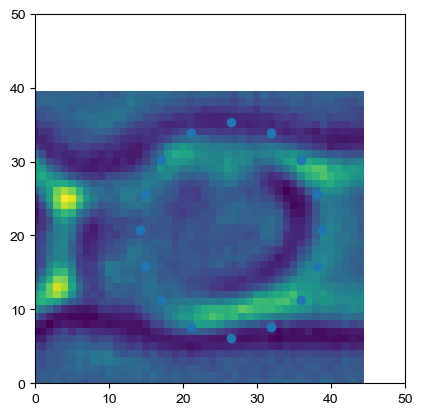

In [335]:
ax = plt.axes()
ax.imshow(cellcrops[0])
ax.scatter(fitted_X, fitted_Y)
ax.set_ylim(0, 50)
ax.set_xlim(0, 50)

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i, df in enumerate(peaks_dfs):
    table = df.pivot_table(index='theta', aggfunc='mean').reset_index()
    
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(cellcrops[i])
    ax.scatter(table.peak_X, table.peak_Y, color='white')
    ax.scatter(table.x_center, table.y_center, color='pink')
    ax.set_title(f'frame {i}') 

# Scratch work for reading ROIs etc.

In [34]:
import skimage
from skimage import io
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import read_roi

from byc import files

In [5]:
bf_stack_path = r"C:\Users\John Cooper\Box Sync\Finkelstein-Matouschek\byc_data\example_byc_expts\20210827_byc\20210827_JPC112_UbiR-NLS-YFP-Su9_BY4741_old_chase\20210827_byc_xy01_cell000_bf_stack.tif"
bf_stack = io.imread(bf_stack_path)

In [16]:
bf_stack.shape

(41, 33, 36)

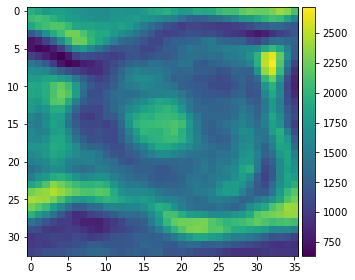

In [15]:
io.imshow(bf_stack[8, :, :])

In [26]:
roi_path = r"C:\Users\John Cooper\Box Sync\Finkelstein-Matouschek\byc_data\example_byc_expts\20210827_byc\20210827_JPC112_UbiR-NLS-YFP-Su9_BY4741_old_chase\20210827_byc_xy01_cell000_bf_stack_measurement_rois.zip"

In [27]:
roi_set = read_roi.read_roi_zip(roi_path)

In [30]:
roi_frame_0 = roi_set['0001-0015-0017']

In [32]:
x = roi_frame_0['x']
y = roi_frame_0['y']

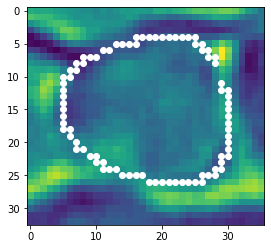

In [41]:
plt.imshow(bf_stack[0, :, :])
plt.scatter(x, y, color='white')

In [39]:
roi_df = files.read_roi_as_df(roi_path)

C:\Users\John Cooper\Box Sync\Finkelstein-Matouschek\byc_data\example_byc_expts\20210827_byc\20210827_JPC112_UbiR-NLS-YFP-Su9_BY4741_old_chase\20210827_byc_xy01_cell000_bf_stack_measurement_rois.zip
0
freehand
1
freehand
2
freehand
3
freehand
4
traced
5
traced
6
traced
7
traced
8
traced
9
traced
10
traced
11
traced
12
traced
13
traced
14
traced
15
traced
16
traced
17
traced
18
traced
19
traced
20
traced
21
traced
22
traced
23
traced
24
traced
25
traced
26
traced
27
traced
28
traced
29
traced
30
traced
31
traced
32
traced
33
traced
34
traced
35
traced
36
traced
37
traced
38
traced
39
traced
40
freehand


In [48]:
frame0_df = roi_df[roi_df.roi_index==0]

In [63]:
roi_df.to_csv('roi_df.csv', index=False)

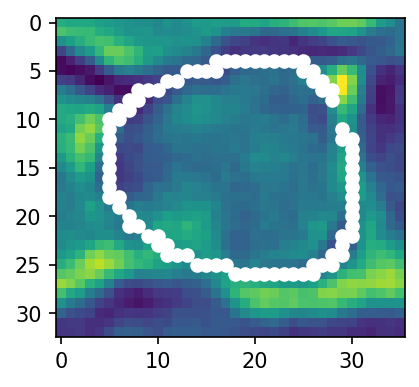

In [65]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(150)

ax = fig.add_subplot(111)

ax.imshow(bf_stack[0, :, :])
ax.scatter(frame0_df.x, frame0_df.y, color='white')